# STEP 3 Audio Preparation and Model


In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
from tqdm.notebook import tqdm
from scipy.stats import kurtosis

In [2]:
#Global parameters
language_dic = {"it" : "Italian", "es" : "Spanish" , "pt": "Portuguese", "ca": "Catalan", "fr": "French", "ro": "Romanian"}
analysis_window_length = 0.01  # 10 ms in seconds
# language_mp3_path = "/Users/Andee/Documents/CBS - Data Science/Second Semester/Machine Learning/Assignments/MLAssignments/FinalProject/languages"
language_mp3_path = "/language_detector/languages"

In [3]:
def get_mp3_filenames_under_duration(threshold: float) -> list:
    mp3_list_under_duration = []
    # get a list of all files in the folder
    language_list = os.listdir(language_mp3_path)
    for language in tqdm(language_list):
        language_path = os.path.join(language_mp3_path, language)
    clips_path = os.path.join(language_path, "clips")

    mp3_list = os.listdir(clips_path)
    mp3_list = mp3_list

    for mp3 in tqdm(mp3_list):
        audio_path = os.path.join(clips_path, mp3)
        audio_samples, fs = sf.read(audio_path)
        clip_duration = len(audio_samples)/fs
        if clip_duration < threshold:
            mp3_list_under_duration.append(mp3)
    return mp3_list_under_duration


In [4]:
# number of repeats defined by minimum duration: ceil(10 seconds / min duration)
min_clip = 0.10115625
x_seconds = 5
num_reps = int(np.ceil(x_seconds / min_clip))
def repeat_audio_x_seconds(track, dur, num_repeats=10, fs=16000):
    num_samples_xs = int(fs * dur)
    track = np.concatenate([track]*num_repeats, axis=0)
    track = track[0:num_samples_xs]
    return track

In [5]:
# data = {"filename": [],"language": [], "mfccs": [], "mfccs_std_dev": [], "mfccs_kurtosis": []}
data = {"filename": [],"language": [], "mfccs": []}

language_list = os.listdir(language_mp3_path)

for language in tqdm(language_list):
    language_path = os.path.join(language_mp3_path, language)

    # Skip non-directory items
    if not os.path.isdir(language_path):
        continue

    if language in language_dic:
        language_name = language_dic[language]
    else:
        print("Unknown language!")
        language_name = language

    clips_path = os.path.join(language_path, "clips")

    # Check if the clips directory exists
    if not os.path.isdir(clips_path):
        print(f"No 'clips' directory found in {language_path}")
        continue

    # get a list of all files in the folder
    mp3_list = os.listdir(clips_path)
    mp3_list = mp3_list
    len(mp3_list)
    # looping through all mp3s in one language
    for mp3 in tqdm(mp3_list):
        # adding the filename as key
        data["filename"].append(mp3)
        # adding the label/language
        data["language"].append(language_name)
        # adding the clip
        audio_path = os.path.join(clips_path, mp3)
        audio_samples, fs = sf.read(audio_path)
        audio_samples = repeat_audio_x_seconds(audio_samples, x_seconds, num_repeats=num_reps, fs=fs)
        y = audio_samples
        sr = fs
        hop_length = int(analysis_window_length * sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128, hop_length=hop_length)
        mfccs_scaled_features = np.mean(mfcc.T,axis=0)
        data["mfccs"].append(mfccs_scaled_features)
        # mfccs_std_dev = np.std(mfcc.T, axis=0)
        # mfccs_kurtosis = kurtosis(mfcc.T, fisher=False)
        # data["mfccs_std_dev"].append(mfccs_std_dev)
        # data["mfccs_kurtosis"].append(mfccs_kurtosis)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8202 [00:00<?, ?it/s]

  0%|          | 0/15033 [00:00<?, ?it/s]

  0%|          | 0/37939 [00:00<?, ?it/s]

  0%|          | 0/7477 [00:00<?, ?it/s]

  0%|          | 0/17619 [00:00<?, ?it/s]

  0%|          | 0/120955 [00:00<?, ?it/s]

In [38]:
df = pd.DataFrame(data)
print(df.head())
df.mfccs[50].shape

                       filename language  \
0  common_voice_it_35774121.mp3  Italian   
1  common_voice_it_35270712.mp3  Italian   
2  common_voice_it_35189998.mp3  Italian   
3  common_voice_it_35109606.mp3  Italian   
4  common_voice_it_36101669.mp3  Italian   

                                               mfccs  
0  [-554.3122417744288, 81.54106470066321, -1.879...  
1  [-423.42635913453483, 80.7660700838481, 14.695...  
2  [-285.1317102023066, 130.41032356911083, 26.76...  
3  [-424.2795894411651, 165.94168126622026, 2.404...  
4  [-392.3644450061149, 113.08899634524744, -35.5...  


(128,)

In [39]:
#Check-point to see if all data was correctly loaded
print(f'The number of files loaded is: {len(df["filename"])}, in {df["language"].nunique()} languages')

The number of files loaded is: 207225, in 6 languages


In [45]:
print(df["mfccs"].shape)
X=np.array(df['mfccs'].tolist())
y=np.array(df['language'].tolist())

(207225,)


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [47]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                                    random_state=42,
                                                    train_size=0.8)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(165780, 128)
(41445, 128)
(165780, 6)
(41445, 6)


Model Creation

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [49]:
### No of classes
num_labels=y.shape[1]

In [50]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(128,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               12900     
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [52]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [53]:
## Training model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100


2023-05-16 21:13:54.353729: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84879360 exceeds 10% of free system memory.


5159/5181 [============================>.] - ETA: 0s - loss: 1.3244 - accuracy: 0.6380
Epoch 1: val_loss improved from inf to 0.67077, saving model to saved_models/audio_classification.hdf5
5181/5181 [==============================] - 8s 1ms/step - loss: 1.3220 - accuracy: 0.6384 - val_loss: 0.6708 - val_accuracy: 0.7782
Epoch 2/100
5145/5181 [============================>.] - ETA: 0s - loss: 0.7380 - accuracy: 0.7493
Epoch 2: val_loss improved from 0.67077 to 0.60091, saving model to saved_models/audio_classification.hdf5
5181/5181 [==============================] - 7s 1ms/step - loss: 0.7376 - accuracy: 0.7494 - val_loss: 0.6009 - val_accuracy: 0.8095
Epoch 3/100
5178/5181 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.7698
Epoch 3: val_loss improved from 0.60091 to 0.57606, saving model to saved_models/audio_classification.hdf5
5181/5181 [==============================] - 7s 1ms/step - loss: 0.6840 - accuracy: 0.7698 - val_loss: 0.5761 - val_accuracy: 0.8102

In [54]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8411629796028137


In [55]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

1296/1296 [==============================] - 1s 585us/step


In [56]:
from sklearn.metrics import classification_report
target_names = sorted(df.language.unique())
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Catalan       0.85      0.96      0.90     24247
      French       0.98      0.21      0.35      1487
     Italian       0.99      0.55      0.71      1587
  Portuguese       0.98      0.63      0.77      2942
    Romanian       0.73      0.80      0.77      7632
     Spanish       1.00      0.66      0.79      3550

    accuracy                           0.84     41445
   macro avg       0.92      0.64      0.71     41445
weighted avg       0.86      0.84      0.83     41445



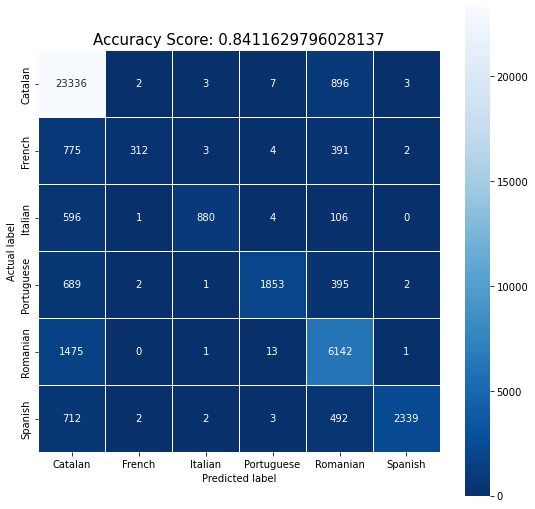

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Plotting the results:
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=target_names, yticklabels=target_names);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy[1])
plt.title(all_sample_title, size = 15);